In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import scipy.stats as stats

from pycaret.classification import *
plt.rcParams['figure.dpi'] = 100

warnings.filterwarnings(action= 'ignore')

#### City of San Diego - Data SD
* Dataset name: Monitoring of Indicator Bacteria in Drinking Water
* URL: https://data.sandiego.gov/datasets/monitoring-of-indicator-bacteria-in-drinking-water/

In [2]:
# All Drinking Water Tests(Bacteria)
df = pd.read_csv('https://seshat.datasd.org/water_testing/indicator_bacteria_tests_datasd_v1.csv')
df.shape

(80585, 9)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80585 entries, 0 to 80584
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FR_NUM        80585 non-null  int64  
 1   date_sampled  80585 non-null  object 
 2   source        80585 non-null  object 
 3   sample_id     80585 non-null  object 
 4   t_coliform    80565 non-null  object 
 5   cl2_total     80585 non-null  float64
 6   e_coli        80576 non-null  object 
 7   temperature   80585 non-null  float64
 8   ph            80585 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 5.5+ MB


In [4]:
# sample of data
df.sample(5)

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph
20484,296490,2017-06-20,50A SYS,W1179531,A,1.67,A,24.7,8.13
29475,319327,2018-10-08,327 SYS,W1266273,A,2.15,A,25.4,7.78
12315,275343,2016-04-04,52 SYS,W1099540,A,1.89,A,19.3,8.07
4153,254770,2015-01-13,230 SYS,W1025596,A,0.59,A,17.2,7.90
243,244908,2014-06-12,150 SYS,W984805,A,2.90,A,23.5,7.80


In [5]:
# Data Dictionary
dict_df = pd.read_csv('https://seshat.datasd.org/water_testing/indicator_bacteria_tests_dictionary_datasd.csv')
dict_df.fillna("")

,Field,Description,Possible values
0,sample_date,Date sample was taken,
1,site_ID,Unique identifier for the sample site,
2,temp_celsius,Temperature in Celsius,
3,chlorine,Chlorine in mg/l or ppm,
4,pH,pH of water sample,0-14
5,coliform,Presence of Coliform indicator bacteria,"A-Absent, P-Present"
6,E.coli,Presence of E.coli indicator bacteria,"A-Absent, P-Present"


In [6]:
# Missing values
df.isnull().sum().sort_values(ascending=False)

t_coliform      20
e_coli           9
FR_NUM           0
date_sampled     0
source           0
sample_id        0
cl2_total        0
temperature      0
ph               0
dtype: int64

In [7]:
# Value counts for t_coliform, to determine how to treat missing values
print(df.t_coliform.fillna("<").value_counts())

# Values A and P are valid according to dictionary, "missing" and "<" values will be removed
# Update 't_coliform' with "<" so that it is easier to delete in next step
df['t_coliform'] = df.t_coliform.fillna("<")

# Since missing values and "<" are not in data dictionary; delete rows
df = df.query("t_coliform != '<'")
print("\n","df shape after dropping t_coliform invalid rows:")
print(df.shape)

# Missing values re-check
print("\n")
print('''Missing values re-check. e_coli missing values were part of 
deleted rows, no further action required for missing data''')
print(df.isnull().sum().sort_values(ascending=False))

A    80333
P      126
<      126
Name: t_coliform, dtype: int64

 df shape after dropping t_coliform invalid rows:
(80459, 9)


Missing values re-check. e_coli missing values were part of 
deleted rows, no further action required for missing data
FR_NUM          0
date_sampled    0
source          0
sample_id       0
t_coliform      0
cl2_total       0
e_coli          0
temperature     0
ph              0
dtype: int64


In [8]:
# Data conversion
df['date_sampled'] =  pd.to_datetime(df.date_sampled)

In [9]:
print('''A value_counts for sample_id shows that there 
are multiple rows per sample_id:''')
df.sample_id.value_counts().head()

A value_counts for sample_id shows that there 
are multiple rows per sample_id:


W1507166    16
W1554396    16
W1515036    16
W1515026    16
W1437490    16
Name: sample_id, dtype: int64

In [10]:
print('''Querying the sample_id values above, shows that FR_NUM, date_sampled, source, 
sample_id, t_coliform, and e_coli are the same values for these multiple rows; however, 
cl2_total, temperature, and ph have similar values but not the same.''')

df.query("sample_id == 'W1377043'")

Querying the sample_id values above, shows that FR_NUM, date_sampled, source, 
sample_id, t_coliform, and e_coli are the same values for these multiple rows; however, 
cl2_total, temperature, and ph have similar values but not the same.


,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph
48442,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.24
48443,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.28
48444,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.24
48445,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.28
48446,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.24
48447,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.3,8.28
48448,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.24
48449,349455,2020-06-29,234A SYS,W1377043,A,0.89,A,23.5,8.28
48450,349455,2020-06-29,234A SYS,W1377043,A,0.90,A,23.3,8.24
48451,349455,2020-06-29,234A SYS,W1377043,A,0.90,A,23.3,8.28


In [11]:
# Create dataframe from value_counts to identify columns that can be updated, as they appear to be duplicates
df2 = df[['FR_NUM', 'date_sampled', 'source', 'sample_id']].value_counts().to_frame(name='Counts')

df2 = df2.reset_index() # places "Counts" into the header row with all other columns

# Only keep columns with Counts greater than 1
df2 = df2.query("Counts > 1")

# Merge values from original dataframe, to get averages for these rows requiring averages for duplicate rows
df2 = df2.merge(df, left_on=('FR_NUM', 'date_sampled', 'source', 'sample_id'), right_on=('FR_NUM', 'date_sampled', 'source', 'sample_id'), how="inner")

In [12]:
# Function to get averages (mean) for cl2_total, temperature, and ph, by FR_NUM
def means(df, frnum):

    fr_num = pd.DataFrame(df.query('FR_NUM == @frnum').FR_NUM.unique()).iloc[0].values[0]
    cl2_total_mean = round(df.query('FR_NUM == @frnum').cl2_total.mean(),3)
    temperature_mean = round(df.query('FR_NUM == @frnum').temperature.mean(),3)
    ph_mean = round(df.query('FR_NUM == @frnum').ph.mean(),2)

    return fr_num,cl2_total_mean, temperature_mean, ph_mean

In [13]:
# Itirate through FR_NUM values to get averages from the means function above
# This process completes in around 1m 29s in Colab (+/- 22 seconds longer than local machine)

df2_means = []

for frn in (df2.FR_NUM.unique()):

    df2_means.append({'FR_NUM': round(pd.DataFrame(means(df2, frn)).iloc[0].values[0]),
                      'cl2_total_mean': pd.DataFrame(means(df2, frn)).iloc[1].values[0],
                      'temperature_mean': pd.DataFrame(means(df2, frn)).iloc[2].values[0],
                      'ph_mean': pd.DataFrame(means(df2, frn)).iloc[3].values[0]})

In [14]:
# Merge average values into original dataframe
df = df.merge(pd.DataFrame(df2_means), left_on=('FR_NUM'), right_on=('FR_NUM'), how="left")

In [15]:
# Make updates to features with variations
# The use of "left" in the merge statement above, left non-duplicate values empty; hence the accounting for them
# in the fillna statements below:
df['cl2_total'] = np.where(df.cl2_total_mean.fillna("") != "", df.cl2_total_mean, df.cl2_total)
df['temperature'] = np.where(df.temperature_mean.fillna("") != "", df.temperature_mean, df.temperature)
df['ph'] = np.where(df.ph_mean.fillna("") != "", df.ph_mean, df.ph)

In [16]:
# With all variations gone, we can now drop duplicates. The two df "shapes" below, are a before and after dropping duplicates.
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(80459, 12)
(59313, 12)


In [17]:
print('''Verify that sample_id values are now unique (1 equals unique):''')
str(pd.DataFrame(df.sample_id.value_counts().to_frame(name='Counts').reset_index()).Counts.unique())

Verify that sample_id values are now unique (1 equals unique):


'[1]'

In [18]:
# Drop unnecessary columns for remainder of the process - used in previous steps
df = df.drop(['cl2_total_mean', 'temperature_mean', 'ph_mean'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59313 entries, 0 to 80458
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FR_NUM        59313 non-null  int64         
 1   date_sampled  59313 non-null  datetime64[ns]
 2   source        59313 non-null  object        
 3   sample_id     59313 non-null  object        
 4   t_coliform    59313 non-null  object        
 5   cl2_total     59313 non-null  float64       
 6   e_coli        59313 non-null  object        
 7   temperature   59313 non-null  float64       
 8   ph            59313 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 4.5+ MB


In [19]:
# View a 5 rows from head of file and 5 rows from tail of file
df

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph
0,244324,2014-06-05,244 SYS,W983115,A,1.91,A,23.4,8.02
1,244325,2014-06-05,245 SYS,W983116,A,1.77,A,24.3,7.99
2,244326,2014-06-05,66 SYS,W983117,A,1.95,A,25.5,8.02
3,244328,2014-06-05,250 SYS,W983119,A,2.40,A,22.6,8.02
4,244329,2014-06-05,248A SYS,W983120,A,1.82,A,24.2,7.96
...,...,...,...,...,...,...,...,...,...
80447,397083,2023-04-10,44 SYS,W1565522,A,1.99,A,17.9,8.06
80448,397084,2023-04-10,60 SYS,W1565523,A,2.95,A,18.5,7.96
80456,397087,2023-04-10,322 SYS,W1565528,A,2.60,A,18.6,8.03
80457,397088,2023-04-10,338 SYS,W1565529,A,1.18,A,19.4,7.95


In [20]:
# Based on the results from the above, it appears the data is ordered by date_sampled

# To ensure that all rows are following this pattern, the next step will 
# sort rows by date_sampled, source, and sample_id to get a chronological

df = df.sort_values(['date_sampled', 'FR_NUM'], ascending=[True, True])

In [21]:
# reset index, drop original index
df.reset_index(drop=True, inplace=True)

#### Outliers


In [22]:
# Outlier Analysis

# this function idea is from the Udemy "Feature Engineering for Machine Learning" course
def diagnostic_plots(df, variable):
    # function takes a dataframe and
    # the variable of interest

    # define plot figure size
    plt.figure(figsize=(16,4))

    # histogram
    plt.subplot(1,3,1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1,3,3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [23]:
# Function to find outliers by their respective high and low boundary, Gaussian distribution
# Got this idea from same Udemy video mentioned above
def find_normal_boundaries(df, variable, distance):

    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    return lower_boundary, upper_boundary

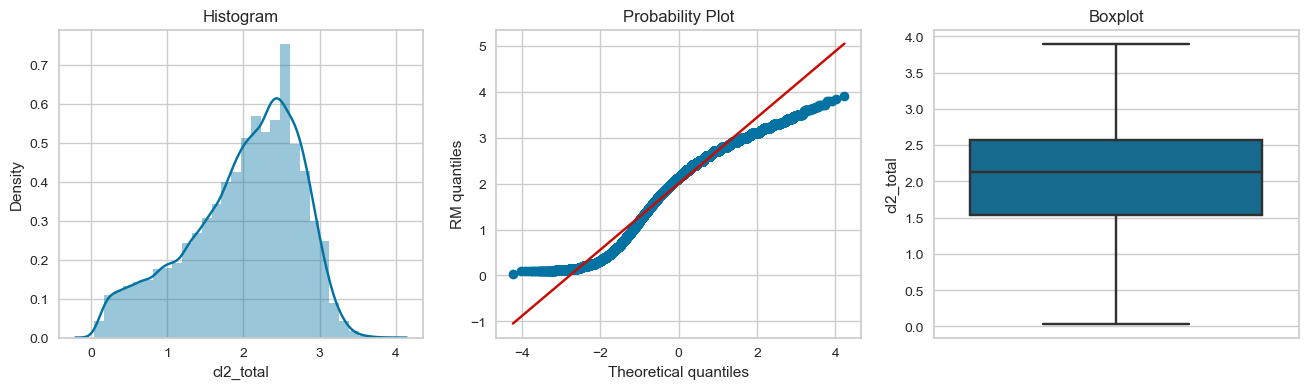

count    59313.000000
mean         1.999511
std          0.735390
min          0.040000
25%          1.540000
50%          2.130000
75%          2.570000
max          3.900000
Name: cl2_total, dtype: float64

In [24]:
diagnostic_plots(df, 'cl2_total')
df.cl2_total.describe()

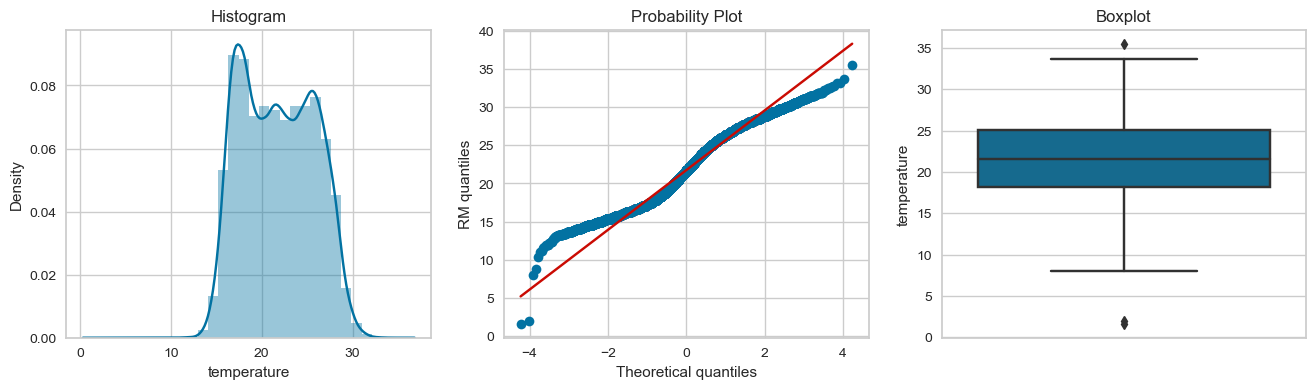

count    59313.000000
mean        21.756096
std          3.974467
min          1.630000
25%         18.200000
50%         21.600000
75%         25.100000
max         35.500000
Name: temperature, dtype: float64

In [25]:
diagnostic_plots(df, 'temperature')
df.temperature.describe()

In [26]:
# find lower and upper boundaries of 'temperature'
temperature_lower_limit, temperature_upper_limit = find_normal_boundaries(df, 'temperature', 3)

# Apply boundaries to outliers
df['temperature'] = np.where(df['temperature'] > temperature_upper_limit, temperature_upper_limit,
                     np.where(df['temperature'] < temperature_lower_limit, temperature_lower_limit,
                      df['temperature']))

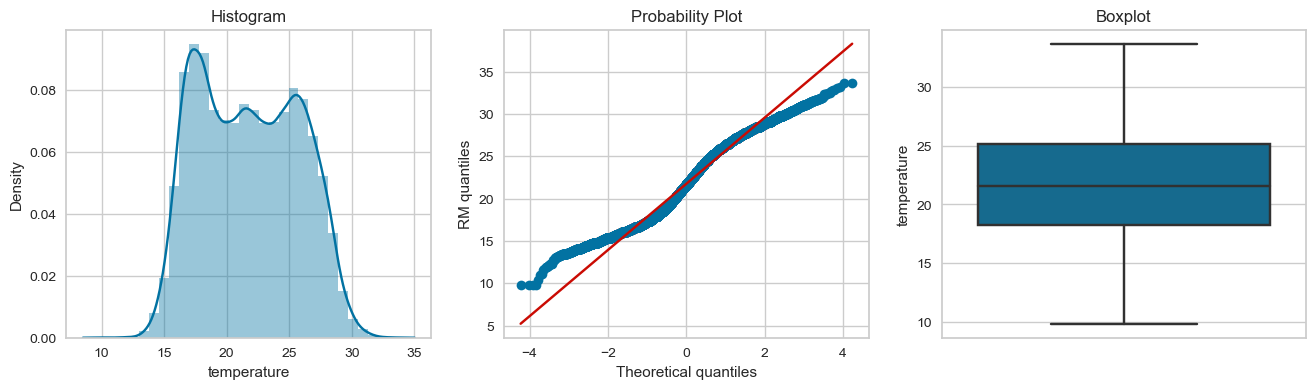

count    59313.000000
mean        21.756385
std          3.973123
min          9.832696
25%         18.200000
50%         21.600000
75%         25.100000
max         33.679497
Name: temperature, dtype: float64

In [27]:
# Verify changes to temperature feature
diagnostic_plots(df, 'temperature')
df.temperature.describe()

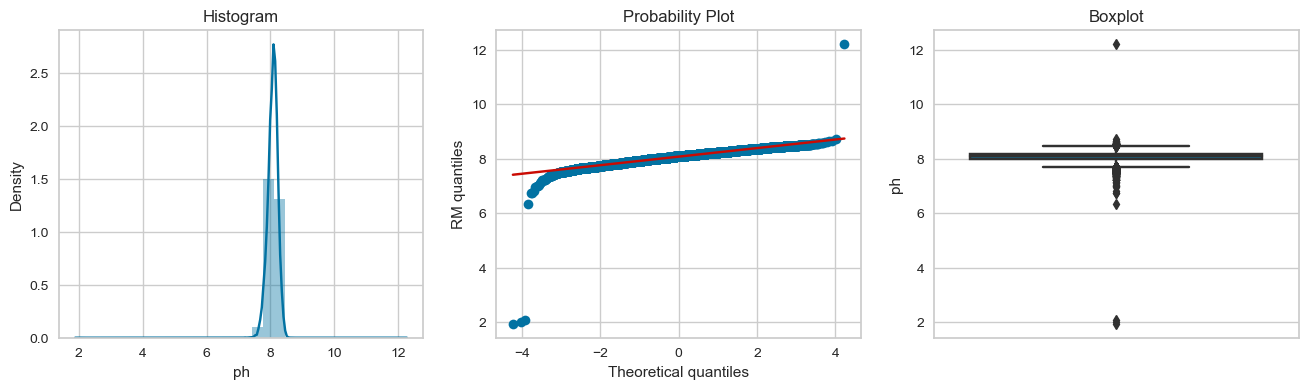

count    59313.000000
mean         8.074456
std          0.163411
min          1.940000
25%          7.980000
50%          8.090000
75%          8.180000
max         12.220000
Name: ph, dtype: float64

In [28]:
diagnostic_plots(df, 'ph')
df.ph.describe()

In [29]:
# find lower and upper boundaries of 'ph'
ph_lower_limit, ph_upper_limit = find_normal_boundaries(df, 'ph', 3)

# Apply boundaries to outliers
df['ph'] = np.where(df['ph'] > ph_upper_limit, ph_upper_limit,
                     np.where(df['ph'] < ph_lower_limit, ph_lower_limit,
                      df['ph']))

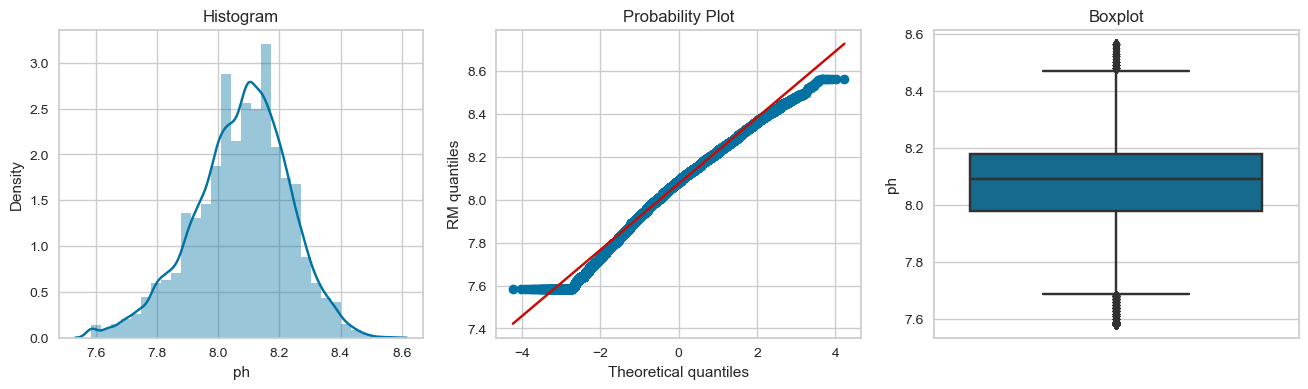

count    59313.000000
mean         8.075070
std          0.154988
min          7.584224
25%          7.980000
50%          8.090000
75%          8.180000
max          8.564687
Name: ph, dtype: float64

In [30]:
diagnostic_plots(df, 'ph')
df.ph.describe()

#### Business purpose (from website)

* A positive result for coliform from one single test is not enough to constitute an MCL (Maximum Contaminant Level) violation. An acute violation occurs when a site that initially tested positive is repeat tested and either the initial sample or one of the repeat samples is positive for E. coli. A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. A positive coliform result from a single routine test may be due to sampling error or bacteria in the testing mechanism but not in the drinking water pipes.

In [31]:
print('''There are no acute violations in the dataset, as all e_coli values equal 'A' 
across all {} rows, which is 'absent' e_coli.'''.format(pd.DataFrame(df.e_coli.value_counts()).iloc[0].values[0]))

df.e_coli.value_counts()

There are no acute violations in the dataset, as all e_coli values equal 'A' 
across all 59313 rows, which is 'absent' e_coli.


A    59313
Name: e_coli, dtype: int64

In [32]:
print('''A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. 
We have 'P', present, values in the t_coliform feature.''',"\n")

df.t_coliform.value_counts()

A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. 
We have 'P', present, values in the t_coliform feature. 



A    59207
P      106
Name: t_coliform, dtype: int64

#### Feature Engineering


In [33]:
# Adding a month-year value to best identify MCL violations
df['year'] = pd.DatetimeIndex(df.date_sampled).year
df['month'] = pd.DatetimeIndex(df.date_sampled).month
df['yearMonth'] =  df.year.astype(str) + '-' + df.month.astype(str)

In [34]:
# Identify yearMonth where t_coliform was Present, 'P'
ym_df = pd.DataFrame(df.query("t_coliform == 'P'").yearMonth.unique())
ym_df.columns = ['yearMonth']

# Get all data from df for yearMonth where there was t_coliform present
ym_df = df.merge(ym_df, left_on='yearMonth', right_on='yearMonth', how='inner')

In [35]:
# Crosstab results, into dataframe
ym_df = pd.DataFrame(pd.crosstab(ym_df.yearMonth, ym_df.t_coliform)).reset_index()

# Add a Total column
ym_df['Total'] = ym_df.A + ym_df.P

# Add a t_coli percent column, representing the percentage of cases in the month, when t_coli was Present
ym_df['yearMonth_t_coli_pct'] = round(ym_df.P / ym_df.Total * 100)

In [36]:
# Add yearMonth_t_coli_pct to main dataframe
df = df.merge(ym_df[['yearMonth', 'yearMonth_t_coli_pct']], left_on='yearMonth', right_on='yearMonth', how='left')

# Update Nan values to 0.0
df['yearMonth_t_coli_pct'] = df.yearMonth_t_coli_pct.fillna(0.0)


# Convert floats to integer
df['yearMonth_t_coli_pct'] = df.yearMonth_t_coli_pct.astype(int)

In [37]:
print('''There are no t_coliform instances per Month, of more than 5% in the dataset.
When present, it has equaled as high as 1% for the respective month only.''',"\n")
df.yearMonth_t_coli_pct.value_counts()

There are no t_coliform instances per Month, of more than 5% in the dataset.
When present, it has equaled as high as 1% for the respective month only. 



0    50925
1     8388
Name: yearMonth_t_coli_pct, dtype: int64

### EDA


##### Subset

In [38]:
df_subset = df[['date_sampled', 't_coliform', 'cl2_total', 'e_coli', 'temperature', 'ph', 'yearMonth_t_coli_pct']]

df_subset

,date_sampled,t_coliform,cl2_total,e_coli,temperature,ph,yearMonth_t_coli_pct
0,2014-06-02,A,2.80,A,22.8,8.03,0
1,2014-06-02,A,2.22,A,23.6,8.00,0
2,2014-06-02,A,1.95,A,25.5,7.99,0
3,2014-06-02,A,1.78,A,24.5,7.95,0
4,2014-06-02,A,2.70,A,22.2,8.02,0
...,...,...,...,...,...,...,...
59308,2023-04-10,A,1.99,A,17.9,8.06,0
59309,2023-04-10,A,2.95,A,18.5,7.96,0
59310,2023-04-10,A,2.60,A,18.6,8.03,0
59311,2023-04-10,A,1.18,A,19.4,7.95,0


##### Get dummies

In [39]:
df_dummies = pd.get_dummies(df_subset.select_dtypes(include='object'))

# join uses index as default on join
df_subset = df_subset.join(df_dummies, how='outer')

# drop 'object' columns
df_subset.drop(columns=df_subset.select_dtypes(include='object').columns.tolist(), inplace=True)

df_subset

,date_sampled,cl2_total,temperature,ph,yearMonth_t_coli_pct,t_coliform_A,t_coliform_P,e_coli_A
0,2014-06-02,2.80,22.8,8.03,0,1,0,1
1,2014-06-02,2.22,23.6,8.00,0,1,0,1
2,2014-06-02,1.95,25.5,7.99,0,1,0,1
3,2014-06-02,1.78,24.5,7.95,0,1,0,1
4,2014-06-02,2.70,22.2,8.02,0,1,0,1
...,...,...,...,...,...,...,...,...
59308,2023-04-10,1.99,17.9,8.06,0,1,0,1
59309,2023-04-10,2.95,18.5,7.96,0,1,0,1
59310,2023-04-10,2.60,18.6,8.03,0,1,0,1
59311,2023-04-10,1.18,19.4,7.95,0,1,0,1


##### Target variable imbalance

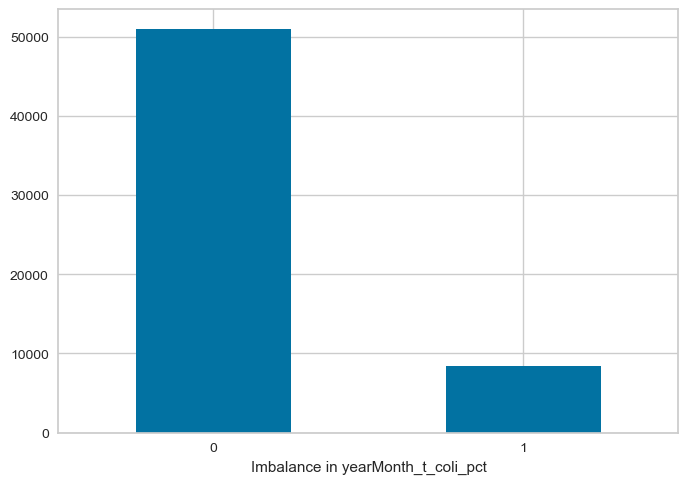

In [40]:
df_subset.yearMonth_t_coli_pct.value_counts().plot(kind='bar', rot=0)
plt.xlabel('Imbalance in yearMonth_t_coli_pct')
plt.show()

##### Pairplot of numerical variables

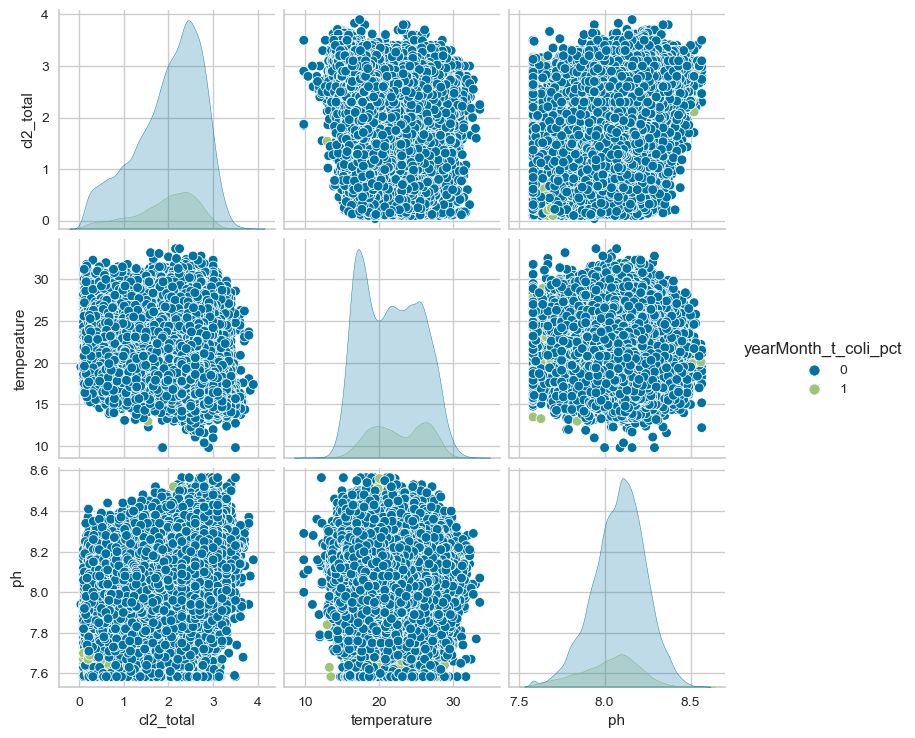

In [41]:
sns.pairplot(df_subset.select_dtypes(include=['float64', 'int64', 'int32']), hue='yearMonth_t_coli_pct')
plt.show()

### Initialize PyCaret

In [42]:
classf = setup(data = df_subset, target = 'yearMonth_t_coli_pct', train_size = 0.8, normalize = True, session_id = 3934)

,Description,Value
0,Session id,3934
1,Target,yearMonth_t_coli_pct
2,Target type,Binary
3,Original data shape,"(59313, 8)"
4,Transformed data shape,"(59313, 10)"
5,Transformed train set shape,"(47450, 10)"
6,Transformed test set shape,"(11863, 10)"
7,Numeric features,6
8,Date features,1
9,Preprocess,True


#### Compare models

In [43]:
compare_models(sort = 'Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2870
rf,Random Forest Classifier,0.9999,1.0000,0.9991,0.9999,0.9995,0.9994,0.9994,0.6570
dt,Decision Tree Classifier,0.9998,0.9995,0.9991,0.9997,0.9994,0.9993,0.9993,0.0890
et,Extra Trees Classifier,0.9998,1.0000,0.9991,0.9993,0.9992,0.9990,0.9990,0.7020
gbc,Gradient Boosting Classifier,0.9907,0.9999,0.9356,0.9989,0.9659,0.9606,0.9615,1.1420
knn,K Neighbors Classifier,0.9643,0.9807,0.8450,0.8968,0.8700,0.8494,0.8499,0.4230
ada,Ada Boost Classifier,0.8821,0.9261,0.3456,0.6582,0.4518,0.3932,0.4195,0.3890
ridge,Ridge Classifier,0.8587,0.0000,0.0025,0.5533,0.0050,0.0038,0.0297,0.0800
qda,Quadratic Discriminant Analysis,0.8586,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0930
dummy,Dummy Classifier,0.8586,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1210


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3934, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### Create the model

In [44]:
model =  create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8759,0.9258,0.2742,0.6434,0.3845,0.3277,0.3648
1,0.8860,0.9189,0.3726,0.6757,0.4803,0.4222,0.4459
2,0.8780,0.9257,0.3070,0.6438,0.4157,0.3570,0.3877
3,0.8782,0.9290,0.3055,0.6467,0.4150,0.3566,0.3880
4,0.8811,0.9260,0.3577,0.6434,0.4598,0.3990,0.4208
5,0.8894,0.9280,0.4128,0.6789,0.5134,0.4552,0.4731
6,0.8790,0.9266,0.3800,0.6174,0.4705,0.4065,0.4218
7,0.8818,0.9273,0.3159,0.6752,0.4305,0.3740,0.4078
8,0.8891,0.9281,0.3964,0.6873,0.5028,0.4455,0.4669


#### Making Predictions

In [45]:
predictions = predict_model(model)

predictions.head(10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,str,0.8855,0.9224,0.3605,0.6798,0.4712,0.4137,0.4399


,date_sampled,cl2_total,temperature,ph,t_coliform_A,t_coliform_P,e_coli_A,yearMonth_t_coli_pct,prediction_label,prediction_score
8473,2015-09-08,2.60,29.700001,8.16,1,0,1,0,0,0.5029
47308,2021-06-24,0.92,27.799999,8.10,1,0,1,0,0,0.6889
11285,2016-02-05,2.19,15.800000,8.01,1,0,1,0,0,0.5268
46830,2021-06-01,2.43,22.400000,8.05,1,0,1,0,0,0.6931
54351,2022-07-13,2.33,26.500000,8.18,1,0,1,0,0,0.6837
6995,2015-06-17,0.36,23.000000,7.86,1,0,1,0,0,0.5197
47551,2021-07-07,1.06,26.600000,8.27,1,0,1,0,0,0.6837
24139,2018-01-09,1.96,18.100000,7.99,1,0,1,1,0,0.5041
12825,2016-04-28,2.08,22.200001,8.38,1,0,1,1,1,0.5018
11641,2016-02-25,2.60,15.800000,8.12,1,0,1,0,0,0.5268


#### Plotting the Model

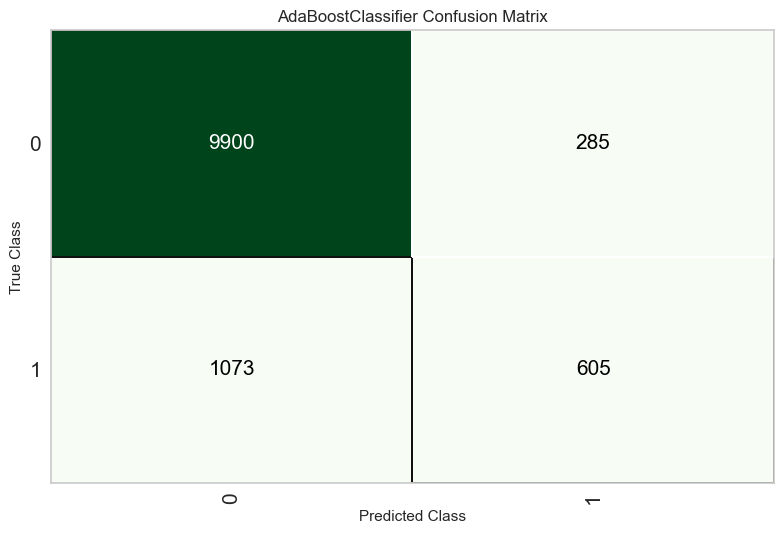

In [46]:
plot_model(model, 'confusion_matrix')

### Create a Target classifier, representing a source that had t_coliform present at any point in the dataset.
### source_t_coliform_historically

In [ ]:
# Identify 'source' which has had t_coliform in the past
source_df = pd.DataFrame(df.query("t_coliform == 'P'").source.unique())
source_df.columns = ['source']
source_df['source_t_coliform_historically'] = 1

In [ ]:
# Merge source_df into main dataframe
df = df.merge(source_df, left_on='source', right_on='source', how='left')

# Convert missing values to 0
df['source_t_coliform_historically'] = df.source_t_coliform_historically.fillna(0)

# Convert to int
df['source_t_coliform_historically'] = df.source_t_coliform_historically.astype(int)

In [ ]:
# initiate sklearn LabelEncoder
le = preprocessing.LabelEncoder()

# LabelEncoder 'source' feature
le.fit(df['source'])
df['source_le'] =  le.transform(df['source'])

# LabelEncoder 'yearMonth' feature
le.fit(df['yearMonth'])
df['yearMonth_le'] =  le.transform(df['yearMonth'])

In [ ]:
# Binary values for t_coliform
df['t_coliform_bin'] = np.where(df.t_coliform == 'A', 0, 1)

## Proposed target variable

<AxesSubplot:>

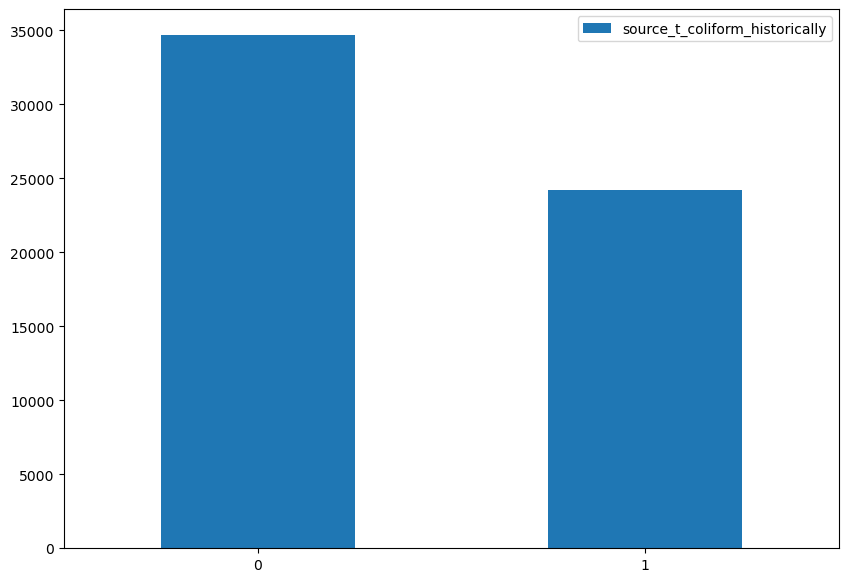

In [ ]:
# More than half of the "sources" have had t_coliform present at some point
pd.DataFrame(df.source_t_coliform_historically.value_counts()).plot.bar(rot=0, stacked=True, figsize=(10,7))

This graph shows ticks for the year when a label encoded source, had t_coliform present,
between the years 2015 through 2018. This is in effort to try and recognize patterns of recurring 
t_coliform at specific sources during this stretch of time. 



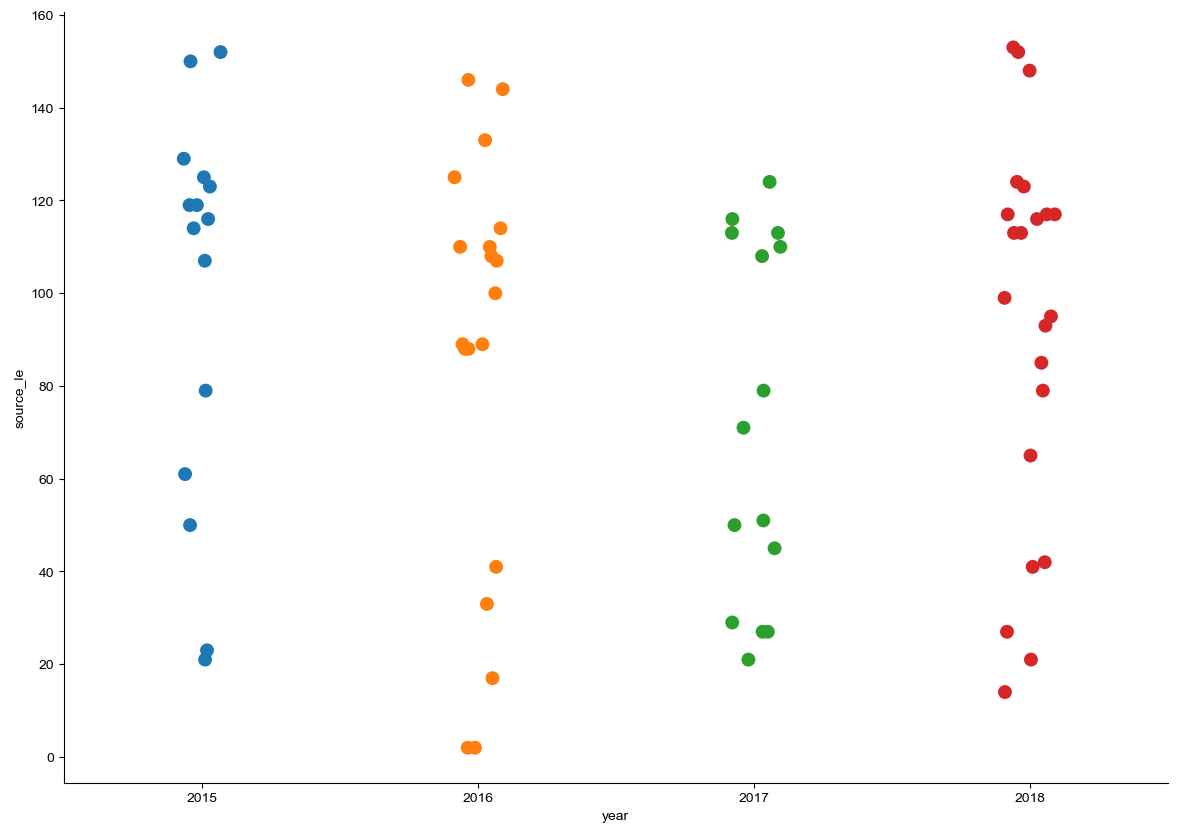

In [ ]:
print('''This graph shows ticks for the year when a label encoded source, had t_coliform present,
between the years 2015 through 2018. This is in effort to try and recognize patterns of recurring 
t_coliform at specific sources during this stretch of time.''',"\n")

sns.catplot(data=df.query("t_coliform_bin == 1 and year <= 2018 and year >= 2015"), x='year', y='source_le', s=10, height=8.27, aspect=11.7/8.27)
sns.set_style("ticks",{'axes.grid' : True})

<AxesSubplot:>

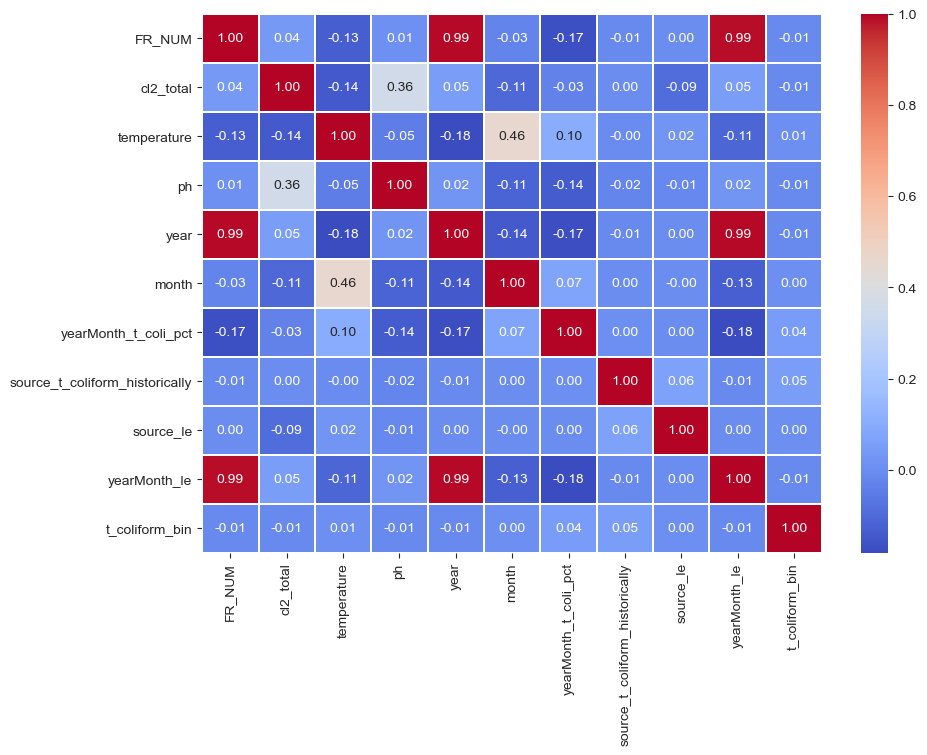

In [ ]:
# Correlation Matrix
pearsoncorr = df.corr(method='pearson')

plt.figure(figsize= (10, 7))

sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            fmt=".2f",
            annot=True,
            linewidth=0.25)